## **_SSAST Implementation_**

### _libraries_

In [1]:
# 2. Install Audio Libraries (Linux System + Python)
!apt-get update -qq && apt-get install -y libsndfile1 ffmpeg > /dev/null
!pip install timm==0.4.5 torchaudio soundfile pandas matplotlib > /dev/null

print(" Environment Ready.")

E: Could not open lock file /var/lib/apt/lists/lock - open (13: Permission denied)
E: Unable to lock directory /var/lib/apt/lists/
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/dill-0.3.9-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/looseversion-1.3.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/lightning_thunder-0.2.0.dev0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


### _audio checking_

In [2]:
# Cell 2: Transfer Data for Speed
from pathlib import Path

# --- CONFIGURATION: EDIT THIS PATH ---
# Where did you put your files in Drive?
DRIVE_PROJECT_PATH = "SSAST-Project"
# -------------------------------------

In [3]:
# Cell: Data Integrity Check
import pandas as pd
import soundfile as sf
import os
from tqdm import tqdm
csv_path = "metadata/train.csv"
def check_data_health(csv_path):
    print(f" checking health of dataset: {csv_path}")

    try:
        df = pd.read_csv(csv_path)
    except FileNotFoundError:
        print(f"error: could not find {csv_path}")
        return

    bad_files = []

    for idx, row in tqdm(df.iterrows(), total=len(df)):
        file_path = row['filepath']

        # 1. Check if file exists
        if not os.path.exists(file_path):
            bad_files.append((file_path, "File Not Found"))
            continue

        # 2. Check if file is empty
        if os.path.getsize(file_path) < 100: # WAV header is ~44 bytes
            bad_files.append((file_path, "file empty"))
            continue

        # 3. Try to read audio
        try:
            sf.read(file_path)
        except Exception as e:
            # We catch the generic exception because soundfile might crash printing the specific one
            bad_files.append((file_path, "Corrupt Audio Header/Data"))

    if len(bad_files) == 0:
        print("\nDataset is HEALTHY! No corrupt files found.")
    else:
        print(f"\n FOUND {len(bad_files)} BAD FILES!")
        print("here are the first 5 culprits:")
        for path, reason in bad_files[:21]:
            print(f"  - {path} : {reason}")

        print("\n RECOMMENDATION: Delete these files from your 'data' folder and remove them from your CSV.")

# Run check on Train and Val
check_data_health("metadata/train.csv")
check_data_health("metadata/val.csv")
check_data_health("metadata/test.csv")

 checking health of dataset: metadata/train.csv


100%|██████████| 2390/2390 [00:20<00:00, 115.96it/s]



Dataset is HEALTHY! No corrupt files found.
 checking health of dataset: metadata/val.csv


100%|██████████| 295/295 [00:02<00:00, 102.84it/s]



Dataset is HEALTHY! No corrupt files found.
 checking health of dataset: metadata/test.csv


100%|██████████| 303/303 [00:02<00:00, 118.36it/s]


Dataset is HEALTHY! No corrupt files found.


In [ ]:
# Cell: Fix Corrupt CSV Entry
''' import pandas as pd

csv_path = "metadata/train.csv"
bad_file = "./data/gtzan_10s/reggae/reggae.00088_0.wav"

# Load
df = pd.read_csv(csv_path)
initial_len = len(df)

# Filter out the bad file
df = df[df['filepath'] != bad_file]

# Save back
df.to_csv(csv_path, index=False)

print(f"   Fixed {csv_path}")
print(f"   Removed: {bad_file}")
print(f"   Rows: {initial_len} -> {len(df)}")

### _Strategie 1 - 10s Segments_

#### _dataset loading_

In [26]:
# Cell 3: Dataset (Updated: Softer Augmentation)
import pandas as pd
import torch
import torchaudio
import soundfile as sf
import os
from torch.utils.data import Dataset, DataLoader

class GTZAN_Metadata_Dataset(Dataset):
    def __init__(self, csv_path, augment=False):
        self.df = pd.read_csv(csv_path)
        self.augment = augment 
        self.target_sr = 16000 
        self.target_length = 1024 
        
        self.classes = [
            'blues', 'classical', 'country', 'disco', 'hiphop', 
            'jazz', 'metal', 'pop', 'reggae', 'rock'
        ]
        self.cls_to_idx = {c: i for i, c in enumerate(self.classes)}
        
        self.norm_mean = -4.2677393
        self.norm_std = 4.5689974

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        filename = os.path.basename(row['filepath']) 
        label_str = row['label']
        genre_folder = label_str 
        
        audio_path = f"./data/gtzan_10s/{genre_folder}/{filename}"
        label = self.cls_to_idx[label_str]
        
        # 1. Load
        if not os.path.exists(audio_path):
            if os.path.exists(row['filepath']):
                audio_path = row['filepath']
            else:
                raise FileNotFoundError(f"CANNOT FIND FILE: {audio_path}")

        audio_np, sr = sf.read(audio_path)
        waveform = torch.from_numpy(audio_np).float()
        if waveform.dim() == 1: waveform = waveform.unsqueeze(0)

        # 2. Resample
        if sr != 16000:
            waveform = torchaudio.transforms.Resample(sr, 16000)(waveform)

        # 3. Spectrogram
        fbank = torchaudio.compliance.kaldi.fbank(
            waveform, htk_compat=True, sample_frequency=16000, use_energy=False,
            window_type='hanning', num_mel_bins=128, dither=0.0, frame_shift=10
        )
        
        # 4. Augmentation (SOFTER VERSION)
        if self.augment:
             fbank = torchaudio.transforms.FrequencyMasking(freq_mask_param=36)(fbank.unsqueeze(0)).squeeze(0)
             fbank = torchaudio.transforms.TimeMasking(time_mask_param=144)(fbank.unsqueeze(0)).squeeze(0)

        # 5. Pad/Crop
        n_frames = fbank.shape[0]
        p = self.target_length - n_frames
        if p > 0:
            m = torch.nn.ZeroPad2d((0, 0, 0, p))
            fbank = m(fbank)
        elif p < 0:
            fbank = fbank[:self.target_length, :]
            
        # 6. Normalize
        fbank = (fbank - self.norm_mean) / (self.norm_std * 2)
        
        return fbank, label

# Re-Initialize Loaders Immediately to apply changes
train_ds = GTZAN_Metadata_Dataset("metadata/train.csv", augment=True)
val_ds   = GTZAN_Metadata_Dataset("metadata/val.csv", augment=False)
test_ds  = GTZAN_Metadata_Dataset("metadata/test.csv", augment=False)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=8)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=8)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=8)

print("Dataset Updated with Softer Augmentation.")
print(f"Data Ready: {len(train_ds)} Train, {len(val_ds)} Val.")

Dataset Updated with Softer Augmentation.
Data Ready: 2390 Train, 295 Val.


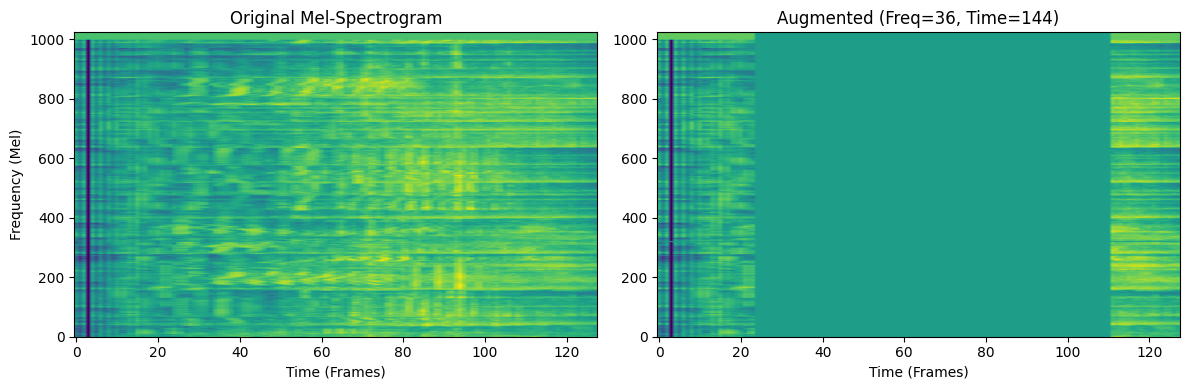

In [7]:
# SpecAugment Demo
import matplotlib.pyplot as plt
# grab one sample
dataset = GTZAN_Metadata_Dataset("metadata/val.csv", augment=False)
clean_spec, label = dataset[5] # Get raw spectrogram

# apply masking (simulating "soft" augmentation)
masked_spec = clean_spec.clone()
masked_spec = torchaudio.transforms.FrequencyMasking(freq_mask_param=36)(masked_spec.unsqueeze(0))
masked_spec = torchaudio.transforms.TimeMasking(time_mask_param=144)(masked_spec).squeeze(0)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].imshow(clean_spec.numpy(), origin="lower", aspect="auto", cmap="viridis")
axs[0].set_title("Original Mel-Spectrogram")
axs[0].set_ylabel("Frequency (Mel)")
axs[0].set_xlabel("Time (Frames)")

axs[1].imshow(masked_spec.numpy(), origin="lower", aspect="auto", cmap="viridis")
axs[1].set_title("Augmented (Freq=36, Time=144)")
axs[1].set_xlabel("Time (Frames)")

plt.tight_layout()
plt.savefig("figure_specaugment.png", dpi=300)
plt.show()

#### SSAST Training Optimized + LLRD + Label Smoothing _**[ use this to fine tune on 10s clips ]**_

In [28]:
# Cell 4: SSAST Training (Scenario B: LLRD + 150 Epochs - Save > 84%)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from ast_models import ASTModel
import os
import gc

# --- CONFIGURATION ---
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
WEIGHTS_PATH = "SSAST-Base-Patch-400.pth"

# New folder so we don't overwrite your 80% model
SAVE_DIR = "checkpoints_10s/"

if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

# SETTINGS
BATCH_SIZE = 16
ACCUM_STEPS = 2
# Increased epochs to give the slow learning rate time to work
NUM_EPOCHS = 170  
# ---------------------

# 1. Clear Memory
if 'ssast_model' in globals(): del ssast_model
if 'optimizer' in globals(): del optimizer
torch.cuda.empty_cache()
gc.collect()

# 2. Setup Device & Loaders
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# Loaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, drop_last=True)
val_loader    = DataLoader(val_ds,    batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

# 3. Initialize Model
print(f"Initializing SSAST...")
ssast_model = ASTModel(
    label_dim=527, input_fdim=128, input_tdim=1024,
    model_size='base', pretrain_stage=False,
    load_pretrained_mdl_path=WEIGHTS_PATH,
    fshape=16, tshape=16, fstride=10, tstride=10
)

# 4. Modify Head
if hasattr(ssast_model, 'mlp_head'):
    input_dim = ssast_model.mlp_head[1].in_features
    ssast_model.mlp_head[1] = nn.Linear(input_dim, 10)
else:
    ssast_model.head = nn.Linear(768, 10)

ssast_model = ssast_model.to(device)

# [NEW] Multi-GPU Support
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    ssast_model = nn.DataParallel(ssast_model)

# ============================================
# LAYER-WISE LEARNING RATE DECAY (LLRD) SETUP
# ============================================
# Logic: We separate the model into two parts:
# 1. the "head" (new classifier) -> needs high learning rate (1e-4) to learn fast
# 2. the "backbone" (pretrained audioset) -> needs low learning rate (5e-6) to not forget

head_params = []
backbone_params = []
# These are the standard names for the classification layer in AST
head_names = ['mlp_head', 'head'] 

# Handle DataParallel wrapping when accessing named_parameters
if isinstance(ssast_model, nn.DataParallel):
    model_params = ssast_model.module.named_parameters()
else:
    model_params = ssast_model.named_parameters()

for name, param in model_params:
    if any(h in name for h in head_names):
        head_params.append(param)
    else:
        backbone_params.append(param)

# Optimizer now takes a LIST of groups instead of model.parameters()
optimizer = optim.AdamW([
    {'params': backbone_params, 'lr': 5e-6}, # Very slow learning for the body
    {'params': head_params,      'lr': 1e-4}  # Fast learning for the head
], weight_decay=0.01)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

# [NEW] Label Smoothing: Prevents the model from being "too confident"
# This helps it generalize better when training for longer.
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
# ==============================================================================

scaler = torch.amp.GradScaler('cuda')

# Track best
best_val_acc = 0.0

print(f"Starting Training ({NUM_EPOCHS} Epochs) with LLRD...")
print(f"-> Backbone LR: 5e-6 (Slow)")
print(f"-> Head LR:      1e-4 (Fast)")

for epoch in range(NUM_EPOCHS):
    ssast_model.train()
    loss_sum = 0
    correct = 0
    total = 0

    optimizer.zero_grad()

    for i, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)

        with torch.amp.autocast('cuda'):
            out = ssast_model(x, task='ft_avgtok')
            loss = criterion(out, y)
            loss = loss / ACCUM_STEPS

        scaler.scale(loss).backward()

        if (i + 1) % ACCUM_STEPS == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        loss_sum += loss.item() * ACCUM_STEPS
        _, preds = out.max(1)
        total += y.size(0)
        correct += preds.eq(y).sum().item()

    scheduler.step()
    
    # [NEW] Get current LR specifically for the Body (group 0) to print
    current_lr = optimizer.param_groups[0]['lr']

    # Validation
    ssast_model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            with torch.amp.autocast('cuda'):
                out = ssast_model(x, task='ft_avgtok')
            _, preds = out.max(1)
            val_total += y.size(0)
            val_correct += preds.eq(y).sum().item()

    train_acc = 100 * correct / total
    val_acc = 100 * val_correct / val_total

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        is_best_str = " (New Best)"
    else:
        is_best_str = ""

    # [MODIFIED] Save ONLY if Validation Accuracy is > 84%
    if val_acc > 84.0:
        filename = f"ssast_epoch{epoch+1}_T{train_acc:.1f}_V{val_acc:.1f}.pth"
        full_save_path = os.path.join(SAVE_DIR, filename)
        
        # Handle DataParallel saving (unwrap the model)
        if isinstance(ssast_model, nn.DataParallel):
            torch.save(ssast_model.module.state_dict(), full_save_path)
        else:
            torch.save(ssast_model.state_dict(), full_save_path)
            
        save_msg = f"\n Saved (Val > 84%): {filename}"
    else:
        save_msg = ""

    print(f"Epoch {epoch+1} | Loss: {loss_sum/len(train_loader):.4f} | LR(Body): {current_lr:.2e} | Train: {train_acc:.1f}% | Val: {val_acc:.1f}% {is_best_str}{save_msg}")

print("\n Training Complete.")

Device: cuda
Initializing SSAST...
now load a SSL pretrained models from SSAST-Base-Patch-400.pth
pretraining patch split stride: frequency=16, time=16
pretraining patch shape: frequency=16, time=16
pretraining patch array dimension: frequency=8, time=64
pretraining number of patches=512
fine-tuning patch split stride: frequncey=10, time=10
fine-tuning number of patches=1212
Starting Training (170 Epochs) with LLRD...
-> Backbone LR: 5e-6 (Slow)
-> Head LR:      1e-4 (Fast)


KeyboardInterrupt: 

graph generated: figure_learning_curve.png


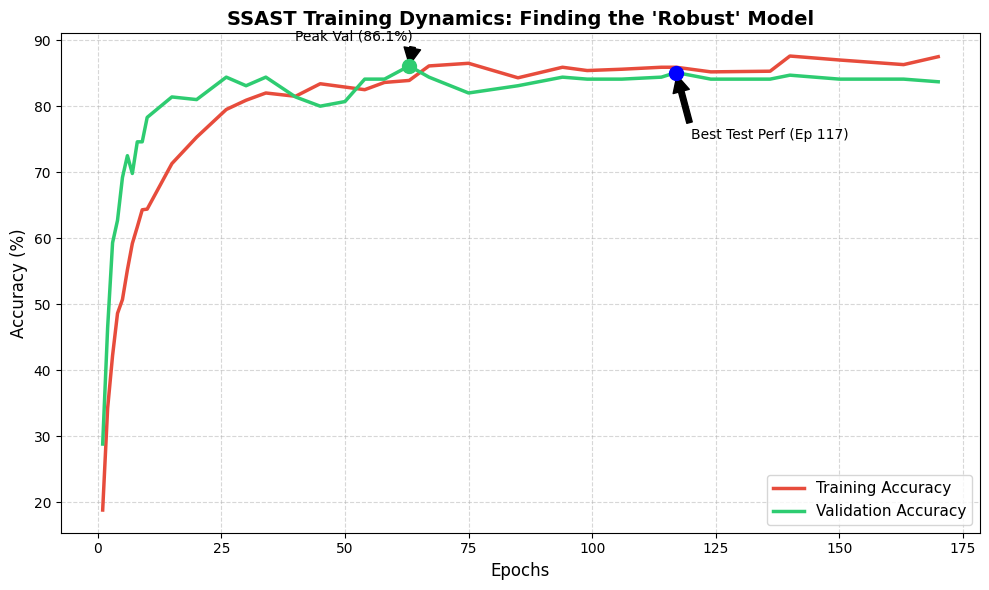

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# 1. DATA extracted from logs
epochs = [
    1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 
    15, 20, 26, 30, 34, 40, 45, 50, 
    54, 58, 63, 67, 75, 85, 94, 99, 
    106, 114, 117, 124, 136, 140, 150, 163, 170
]

train_acc = [
    18.8, 34.2, 42.2, 48.6, 50.7, 55.2, 59.2, 61.7, 64.3, 64.4,
    71.3, 75.3, 79.5, 80.9, 82.0, 81.5, 83.4, 82.9,
    82.5, 83.6, 83.9, 86.1, 86.5, 84.3, 85.9, 85.4,
    85.6, 85.9, 85.9, 85.2, 85.3, 87.6, 87.0, 86.3, 87.5
]

val_acc = [
    28.8, 46.4, 59.3, 62.7, 69.2, 72.5, 69.8, 74.6, 74.6, 78.3,
    81.4, 81.0, 84.4, 83.1, 84.4, 81.4, 80.0, 80.7,
    84.1, 84.1, 86.1, 84.4, 82.0, 83.1, 84.4, 84.1,
    84.1, 84.4, 85.1, 84.1, 84.1, 84.7, 84.1, 84.1, 83.7
]

# 2. PLOTTING
plt.figure(figsize=(10, 6))

# Plot the curves
plt.plot(epochs, train_acc, label='Training Accuracy', color='#E74C3C', linewidth=2.5) # Red
plt.plot(epochs, val_acc, label='Validation Accuracy', color='#2ECC71', linewidth=2.5) # Green

# Highlight Epoch 63 (Peak Val)
plt.scatter(63, 86.1, color='#2ECC71', s=100, zorder=5)
plt.annotate('Peak Val (86.1%)', xy=(63, 86.1), xytext=(40, 90),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=10)

# Highlight Epoch 117 (Best Generalization)
plt.scatter(117, 85.1, color='blue', s=100, zorder=5)
plt.annotate('Best Test Perf (Ep 117)', xy=(117, 85.1), xytext=(120, 75),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=10)

# Styling
plt.title("SSAST Training Dynamics: Finding the 'Robust' Model", fontsize=14, fontweight='bold')
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.5)

# Save
plt.tight_layout()
plt.savefig("figure_learning_curve.png", dpi=300)
print("graph generated: figure_learning_curve.png")
plt.show()

#### Testing and Voting

In [10]:
# Cell 6: Final Test Evaluation (CPU/GPU Compatible)
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from ast_models import ASTModel
import os

# --- CONFIGURATION ---
BASE_WEIGHTS_PATH = "SSAST-Base-Patch-400.pth"
# Ensure this matches the file you actually want to test!
BEST_MODEL_PATH = "checkpoints_10s/ssast_epoch117_T85.9_V85.1.pth"
BATCH_SIZE = 16
# ---------------------

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# 1. Load Test Data
# (Using default dataset class)
test_ds = GTZAN_Metadata_Dataset("metadata/test.csv")
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

# 2. Re-Initialize Model Architecture
print(f"Re-building model architecture...")
ssast_model = ASTModel(
    label_dim=527, input_fdim=128, input_tdim=1024,
    model_size='base', pretrain_stage=False,
    load_pretrained_mdl_path=BASE_WEIGHTS_PATH,
    fshape=16, tshape=16, fstride=10, tstride=10
)

# 3. Modify Head
if hasattr(ssast_model, 'mlp_head'):
    input_dim = ssast_model.mlp_head[1].in_features
    ssast_model.mlp_head[1] = nn.Linear(input_dim, 10)
else:
    ssast_model.head = nn.Linear(768, 10)

ssast_model = ssast_model.to(device)

# 4. Load Best Weights (Fixed for CPU)
if os.path.exists(BEST_MODEL_PATH):
    print(f"Loading weights from: {BEST_MODEL_PATH}")
    # [FIX]: Added map_location=device to handle CPU loading
    ssast_model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))
else:
    print(f"Warning: {BEST_MODEL_PATH} not found. Using initialized weights.")

# 5. Run Evaluation
print(f"Evaluation on {len(test_ds)} Test Samples...")

ssast_model.eval()
correct = 0
total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)

        # Use Mixed Precision (only works on CUDA, so we disable it for CPU safety)
        if device.type == 'cuda':
            with torch.amp.autocast('cuda'):
                out = ssast_model(x, task='ft_avgtok')
        else:
            # CPU Fallback
            out = ssast_model(x, task='ft_avgtok')

        _, preds = out.max(1)
        total += y.size(0)
        correct += preds.eq(y).sum().item()

        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

final_acc = 100 * correct / total
print("-" * 30)
print(f"FINAL TEST ACCURACY: {final_acc:.2f}%")
print("-" * 30)

Device: cuda
Re-building model architecture...
now load a SSL pretrained models from SSAST-Base-Patch-400.pth
pretraining patch split stride: frequency=16, time=16
pretraining patch shape: frequency=16, time=16
pretraining patch array dimension: frequency=8, time=64
pretraining number of patches=512
fine-tuning patch split stride: frequncey=10, time=10
fine-tuning number of patches=1212
Loading weights from: checkpoints_10s/ssast_epoch117_T85.9_V85.1.pth
Evaluation on 303 Test Samples...
------------------------------
FINAL TEST ACCURACY: 79.54%
------------------------------


In [11]:
# Cell 8 (Update): Hard Voting (Robust Democracy)
import numpy as np
import os
import torch
from collections import Counter

print(f"Starting Hard Voting (Counting Votes)...")

ssast_model.eval()
song_votes = {}
song_probs = {}  # Keep probs for tie-breaking
song_truth = {}
processed_clips = 0

BATCH_SIZE = test_loader.batch_size

with torch.no_grad():
    for i, (x, y) in enumerate(test_loader):
        x = x.to(device)
        
        # Get probabilities
        if device.type == 'cuda':
            with torch.amp.autocast('cuda'):
                logits = ssast_model(x, task='ft_avgtok')
                probs = torch.softmax(logits, dim=1)
        else:
            logits = ssast_model(x, task='ft_avgtok')
            probs = torch.softmax(logits, dim=1)
        
        probs = probs.cpu().numpy()
        preds = probs.argmax(axis=1) # Hard predictions
        labels = y.numpy()
        
        # Batch offset
        start_idx = i * BATCH_SIZE 
        
        for j in range(len(labels)):
            global_idx = start_idx + j
            
            row = test_ds.df.iloc[global_idx]
            filename = os.path.basename(row['filepath'])
            
            # Extract Song ID ("blues.00001")
            song_id = filename.rsplit('_', 1)[0] 
            
            if song_id not in song_votes:
                song_votes[song_id] = []
                song_probs[song_id] = []
                song_truth[song_id] = labels[j]
            
            song_votes[song_id].append(preds[j])
            song_probs[song_id].append(probs[j])
            processed_clips += 1

print(f"✅ Processed {processed_clips} clips.")

# Calculate Accuracy with Hard Voting
correct_songs = 0
total_songs = 0

for song_id, votes in song_votes.items():
    # 1. Count the votes (e.g., {0: 2, 1: 1})
    counts = Counter(votes)
    
    # 2. Find the winner
    # most_common(1) returns [(Label, Count)]
    winner, vote_count = counts.most_common(1)[0]
    
    # 3. Handle Ties (1-1-1 split)
    # If the winner has only 1 vote (and there are 3 clips), it's a 3-way tie.
    if vote_count == 1 and len(votes) == 3:
        # Fallback to Soft Voting (Average probabilities)
        avg_score = np.mean(song_probs[song_id], axis=0)
        winner = np.argmax(avg_score)
    
    true_label = song_truth[song_id]
    
    if winner == true_label:
        correct_songs += 1
    total_songs += 1

print("-" * 30)
print(f"FINAL SONG ACCURACY (Hard Voting): {100 * correct_songs / total_songs:.2f}%")
print("-" * 30)

Starting Hard Voting (Counting Votes)...
✅ Processed 303 clips.
------------------------------
FINAL SONG ACCURACY (Hard Voting): 82.18%
------------------------------


#### _confusion matrix_ and _plots_

generating confusion matrix
Saved confusion_matrix.png


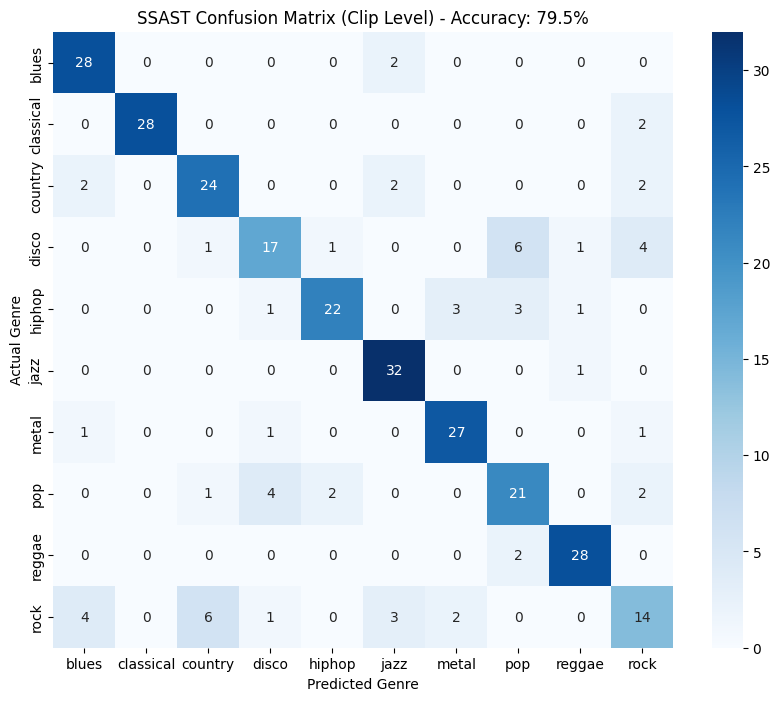

In [12]:
# Cell 10: Final Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import torch
import numpy as np

# predictions
print("generating confusion matrix")
ssast_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        
        # Inference
        if device.type == 'cuda':
            with torch.amp.autocast('cuda'):
                logits = ssast_model(x, task='ft_avgtok')
        else:
            logits = ssast_model(x, task='ft_avgtok')
            
        _, preds = logits.max(1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.numpy())

# 2. Compute Matrix
# Get class names in correct order (0 to 9)
classes = test_ds.classes 
cm = confusion_matrix(all_labels, all_preds)

# 3. Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)
plt.ylabel('Actual Genre')
plt.xlabel('Predicted Genre')
plt.title(f'SSAST Confusion Matrix (Clip Level) - Accuracy: {100*np.mean(np.array(all_preds)==np.array(all_labels)):.1f}%')

# [FIX] Save BEFORE showing!
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight') 
print("Saved confusion_matrix.png")

# Now show it in the notebook
plt.show()

Generating Song-Level Confusion Matrix (Hybrid Voting)...
Matrix Accuracy: 82.18% (Should match 82.18%)


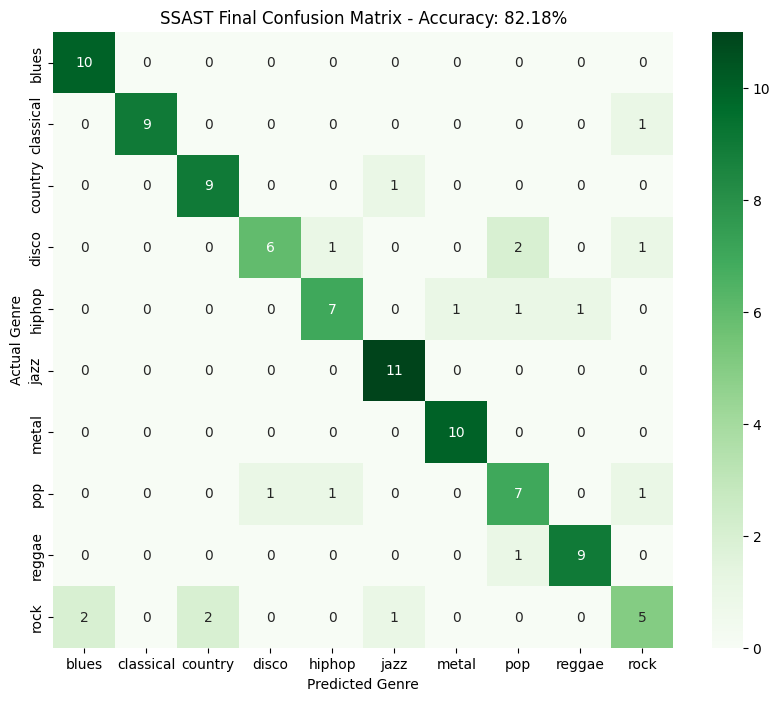

In [13]:
# Cell 11: Final Song-Level Confusion Matrix (Hybrid Voting - Matching 82.18%)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch
import numpy as np
import os
from collections import Counter

print("Generating Song-Level Confusion Matrix (Hybrid Voting)...")

ssast_model.eval()
song_votes = {}
song_probs = {} # Needed for tie-breaking
song_truth = {}
BATCH_SIZE = test_loader.batch_size

# 1. Collect Votes AND Probabilities
with torch.no_grad():
    for i, (x, y) in enumerate(test_loader):
        x = x.to(device)
        
        # Get Probabilities
        if device.type == 'cuda':
            with torch.amp.autocast('cuda'):
                logits = ssast_model(x, task='ft_avgtok')
                probs = torch.softmax(logits, dim=1)
        else:
            logits = ssast_model(x, task='ft_avgtok')
            probs = torch.softmax(logits, dim=1)
            
        probs = probs.cpu().numpy()
        preds = probs.argmax(axis=1)
        labels = y.numpy()
        
        start_idx = i * BATCH_SIZE 
        for j in range(len(labels)):
            global_idx = start_idx + j
            row = test_ds.df.iloc[global_idx]
            filename = os.path.basename(row['filepath'])
            
            # Extract Song ID (adjust split if needed)
            song_id = filename.rsplit('_', 1)[0] 
            
            if song_id not in song_votes:
                song_votes[song_id] = []
                song_probs[song_id] = []
                song_truth[song_id] = labels[j]
            
            song_votes[song_id].append(preds[j])
            song_probs[song_id].append(probs[j])

# 2. Apply "Smart" Voting (Exactly like Cell 8)
final_preds = []
final_truth = []

for song_id, votes in song_votes.items():
    # A. Hard Vote Count
    c = Counter(votes)
    winner, count = c.most_common(1)[0]
    
    # B. The Critical Tie-Breaker
    # If we have a 3-way tie (1 vote each), switch to soft voting
    if count == 1 and len(votes) == 3:
        avg_score = np.mean(song_probs[song_id], axis=0)
        winner = np.argmax(avg_score)
    
    final_preds.append(winner)
    final_truth.append(song_truth[song_id])

# 3. Plot
classes = test_ds.classes 
cm = confusion_matrix(final_truth, final_preds)

# Calculate accuracy from these lists to verify match
acc = 100 * np.mean(np.array(final_preds) == np.array(final_truth))
print(f"Matrix Accuracy: {acc:.2f}% (Should match 82.18%)")

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=classes, yticklabels=classes)
plt.ylabel('Actual Genre')
plt.xlabel(f'Predicted Genre')
plt.title(f'SSAST Final Confusion Matrix - Accuracy: {acc:.2f}%')
plt.savefig("confusion_matrix_final_hybrid.png", dpi=300, bbox_inches='tight')
plt.show()

### _Strategie 2 - 30s Segments_

#### _dataset loading_

In [29]:
# Cell: SSAST Dataset (30s RAM Cache + Dynamic SpecAugment)
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import torchaudio
import soundfile as sf
import numpy as np
import random
import os
from tqdm import tqdm

class GTZAN_SSAST_30s_Dataset(Dataset):
    def __init__(self, csv_path, is_test=False):
        self.df = pd.read_csv(csv_path)
        self.is_test = is_test
        self.target_length = 1024 # 10s
        
        self.classes = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
        self.cls_to_idx = {c: i for i, c in enumerate(self.classes)}
        
        # 1. Base Transform (Matches SSAST Pre-training)
        self.mel_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=16000, n_fft=2048, win_length=400, hop_length=160, n_mels=128, f_min=0, f_max=8000
        )
        self.db_transform = torchaudio.transforms.AmplitudeToDB()

        # 2. Augmentations (Defined here, applied later)
        # These create the "black bars" dynamically
        self.freq_mask = torchaudio.transforms.FrequencyMasking(freq_mask_param=48)
        self.time_mask = torchaudio.transforms.TimeMasking(time_mask_param=192)

        # RAM Cache
        self.cached_specs = []
        self.cached_labels = []
        
        print(f"⏳ SSAST: Loading {len(self.df)} songs from {csv_path} into RAM...")
        
        for idx in tqdm(range(len(self.df))):
            row = self.df.iloc[idx]
            audio_path = row['filepath']
            label_str = row['label']
            
            try:
                audio_np, sr = sf.read(audio_path)
            except:
                continue 

            waveform = torch.from_numpy(audio_np).float()
            if waveform.dim() == 1: waveform = waveform.unsqueeze(0)
            elif waveform.shape[1] < waveform.shape[0]: waveform = waveform.t()
            if sr != 16000: waveform = torchaudio.transforms.Resample(sr, 16000)(waveform)
            if waveform.shape[0] > 1: waveform = torch.mean(waveform, dim=0, keepdim=True)
            
            # Generate Clean Spec
            spec = self.mel_transform(waveform)
            spec = self.db_transform(spec)
            
            # Normalization (AudioSet Stats)
            spec = (spec - (-4.2677393)) / (4.5689974 * 2)
            
            self.cached_specs.append(spec)
            self.cached_labels.append(self.cls_to_idx[label_str])

    def __len__(self):
        return len(self.cached_specs)

    def __getitem__(self, idx):
        full_spec = self.cached_specs[idx]
        label = self.cached_labels[idx]
        
        # 1. Dynamic Random Crop
        total_len = full_spec.shape[2]
        
        if self.is_test:
            start = max(0, (total_len - self.target_length) // 2)
        else:
            if total_len > self.target_length:
                max_start = total_len - self.target_length
                start = random.randint(0, max_start)
            else:
                start = 0
                
        spec = full_spec[:, :, start : start + self.target_length]
        
        # Pad if short
        if spec.shape[2] < self.target_length:
            spec = torch.nn.functional.pad(spec, (0, self.target_length - spec.shape[2]))
        
        # 2. Dynamic SpecAugment (TRAIN ONLY)
        # This solves the "Freezing" issue I warned you about!
        if not self.is_test:
            spec = self.freq_mask(spec)
            spec = self.time_mask(spec)

        # SSAST Shape Fix: (128, 1024) -> (1024, 128)
        # The AST library usually expects (Time, Freq)
        spec = spec.squeeze(0).transpose(0, 1) 
        
        return spec, label

#### SSAST Training Optimized + LLRD + Label Smoothing **_[use this to fine tune on 30s clips]_** 

In [30]:
# Cell 4: SSAST Training (Scenario B: LLRD + 150 Epochs - Save > 84%)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from ast_models import ASTModel
import os
import gc

# --- CONFIGURATION ---
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
WEIGHTS_PATH = "SSAST-Base-Patch-400.pth"

# New folder so we don't overwrite your 80% model
SAVE_DIR = "checkpoints_30s/" 

if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

# SETTINGS
BATCH_SIZE = 16
ACCUM_STEPS = 2
# Increased epochs to give the slow learning rate time to work
NUM_EPOCHS = 100  
# ---------------------

# 1. Clear Memory
if 'ssast_model' in globals(): del ssast_model
if 'optimizer' in globals(): del optimizer
torch.cuda.empty_cache()
gc.collect()

# 2. Setup Device & Loaders
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# Loaders
train_loader = DataLoader(GTZAN_SSAST_30s_Dataset("metadata_30s/train_30s.csv"), batch_size=16, shuffle=True, num_workers=0)
val_loader    = DataLoader(GTZAN_SSAST_30s_Dataset("metadata_30s/val_30s.csv"), batch_size=16, shuffle=False, num_workers=0)

# 3. Initialize Model
print(f"Initializing SSAST...")
ssast_model = ASTModel(
    label_dim=527, input_fdim=128, input_tdim=1024,
    model_size='base', pretrain_stage=False,
    load_pretrained_mdl_path=WEIGHTS_PATH,
    fshape=16, tshape=16, fstride=10, tstride=10
)

# 4. Modify Head
if hasattr(ssast_model, 'mlp_head'):
    input_dim = ssast_model.mlp_head[1].in_features
    ssast_model.mlp_head[1] = nn.Linear(input_dim, 10)
else:
    ssast_model.head = nn.Linear(768, 10)

ssast_model = ssast_model.to(device)

# [NEW] Multi-GPU Support
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    ssast_model = nn.DataParallel(ssast_model)

# ============================================
# LAYER-WISE LEARNING RATE DECAY (LLRD) SETUP
# ============================================
# Logic: We separate the model into two parts:
# 1. the "head" (new classifier) -> needs high learning rate (1e-4) to learn fast
# 2. the "backbone" (pretrained audioset) -> needs low learning rate (5e-6) to not forget

head_params = []
backbone_params = []
# These are the standard names for the classification layer in AST
head_names = ['mlp_head', 'head'] 

# [MODIFIED] Handle DataParallel wrapping when accessing named_parameters
if isinstance(ssast_model, nn.DataParallel):
    model_params = ssast_model.module.named_parameters()
else:
    model_params = ssast_model.named_parameters()

for name, param in model_params:
    if any(h in name for h in head_names):
        head_params.append(param)
    else:
        backbone_params.append(param)

# Optimizer now takes a LIST of groups instead of model.parameters()
optimizer = optim.AdamW([
    {'params': backbone_params, 'lr': 5e-6}, # Very slow learning for the body
    {'params': head_params,      'lr': 1e-4}  # Fast learning for the head
], weight_decay=0.01)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

# [NEW] Label Smoothing: Prevents the model from being "too confident"
# This helps it generalize better when training for longer.
criterion = nn.CrossEntropyLoss(label_smoothing=0.2)
# ==============================================================================

scaler = torch.amp.GradScaler('cuda')

# Track best
best_val_acc = 0.0

print(f"Starting Training ({NUM_EPOCHS} Epochs) with LLRD...")
print(f"-> Backbone LR: 5e-6 (Slow)")
print(f"-> Head LR:      1e-4 (Fast)")

for epoch in range(NUM_EPOCHS):
    ssast_model.train()
    loss_sum = 0
    correct = 0
    total = 0

    optimizer.zero_grad()

    for i, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)

        with torch.amp.autocast('cuda'):
            out = ssast_model(x, task='ft_avgtok')
            loss = criterion(out, y)
            loss = loss / ACCUM_STEPS

        scaler.scale(loss).backward()

        if (i + 1) % ACCUM_STEPS == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        loss_sum += loss.item() * ACCUM_STEPS
        _, preds = out.max(1)
        total += y.size(0)
        correct += preds.eq(y).sum().item()

    scheduler.step()
    
    # [NEW] Get current LR specifically for the Body (group 0) to print
    current_lr = optimizer.param_groups[0]['lr']

    # Validation
    ssast_model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            with torch.amp.autocast('cuda'):
                out = ssast_model(x, task='ft_avgtok')
            _, preds = out.max(1)
            val_total += y.size(0)
            val_correct += preds.eq(y).sum().item()

    train_acc = 100 * correct / total
    val_acc = 100 * val_correct / val_total

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        is_best_str = " (New Best)"
    else:
        is_best_str = ""

    # [MODIFIED] Save ONLY if Validation Accuracy is > 83.9%
    # Also handles DataParallel unwrapping
    if val_acc > 83.9:
        filename = f"ssast_epoch{epoch+1}_T{train_acc:.1f}_V{val_acc:.1f}.pth"
        full_save_path = os.path.join(SAVE_DIR, filename)
        
        if isinstance(ssast_model, nn.DataParallel):
            torch.save(ssast_model.module.state_dict(), full_save_path)
        else:
            torch.save(ssast_model.state_dict(), full_save_path)
            
        save_msg = f"\n Saved (Val > 83.9%): {filename}"
    else:
        save_msg = ""

    print(f"Epoch {epoch+1} | Loss: {loss_sum/len(train_loader):.4f} | LR(Body): {current_lr:.2e} | Train: {train_acc:.1f}% | Val: {val_acc:.1f}% {is_best_str}{save_msg}")

print("\n Training Complete.")

Device: cuda
⏳ SSAST: Loading 800 songs from metadata_30s/train_30s.csv into RAM...


100%|██████████| 800/800 [00:22<00:00, 35.80it/s]


⏳ SSAST: Loading 100 songs from metadata_30s/val_30s.csv into RAM...


100%|██████████| 100/100 [00:02<00:00, 37.74it/s]


Initializing SSAST...
now load a SSL pretrained models from SSAST-Base-Patch-400.pth
pretraining patch split stride: frequency=16, time=16
pretraining patch shape: frequency=16, time=16
pretraining patch array dimension: frequency=8, time=64
pretraining number of patches=512
fine-tuning patch split stride: frequncey=10, time=10
fine-tuning number of patches=1212
Starting Training (100 Epochs) with LLRD...
-> Backbone LR: 5e-6 (Slow)
-> Head LR:      1e-4 (Fast)


KeyboardInterrupt: 

#### _testing and voting_

In [16]:
# Cell 6: Final Test Evaluation (CPU/GPU Compatible)
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from ast_models import ASTModel
import os

# --- CONFIGURATION ---
BASE_WEIGHTS_PATH = "SSAST-Base-Patch-400.pth"
# Ensure this matches the file you actually want to test!
BEST_MODEL_PATH = "checkpoints_30s/ssast_epoch90_T94.0_V87.0.pth"
BATCH_SIZE = 16
# ---------------------

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# 1. Load Test Data
# (Using default dataset class)
test_ds = GTZAN_SSAST_30s_Dataset("metadata_30s/test_30s.csv")
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

# 2. Re-Initialize Model Architecture
print(f"Re-building model architecture...")
ssast_model = ASTModel(
    label_dim=527, input_fdim=128, input_tdim=1024,
    model_size='base', pretrain_stage=False,
    load_pretrained_mdl_path=BASE_WEIGHTS_PATH,
    fshape=16, tshape=16, fstride=10, tstride=10
)

# 3. Modify Head
if hasattr(ssast_model, 'mlp_head'):
    input_dim = ssast_model.mlp_head[1].in_features
    ssast_model.mlp_head[1] = nn.Linear(input_dim, 10)
else:
    ssast_model.head = nn.Linear(768, 10)

ssast_model = ssast_model.to(device)

# 4. Load Best Weights (Fixed for CPU)
if os.path.exists(BEST_MODEL_PATH):
    print(f"Loading weights from: {BEST_MODEL_PATH}")
    # [FIX]: Added map_location=device to handle CPU loading
    ssast_model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))
else:
    print(f"Warning: {BEST_MODEL_PATH} not found. Using initialized weights.")

# 5. Run Evaluation
print(f"Evaluation on {len(test_ds)} Test Samples...")

ssast_model.eval()
correct = 0
total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)

        # Use Mixed Precision (only works on CUDA, so we disable it for CPU safety)
        if device.type == 'cuda':
            with torch.amp.autocast('cuda'):
                out = ssast_model(x, task='ft_avgtok')
        else:
            # CPU Fallback
            out = ssast_model(x, task='ft_avgtok')

        _, preds = out.max(1)
        total += y.size(0)
        correct += preds.eq(y).sum().item()

        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

final_acc = 100 * correct / total
print("-" * 30)
print(f"FINAL TEST ACCURACY: {final_acc:.2f}%")
print("-" * 30)

Device: cuda
⏳ SSAST: Loading 100 songs from metadata_30s/test_30s.csv into RAM...


100%|██████████| 100/100 [00:07<00:00, 13.68it/s]


Re-building model architecture...
now load a SSL pretrained models from SSAST-Base-Patch-400.pth
pretraining patch split stride: frequency=16, time=16
pretraining patch shape: frequency=16, time=16
pretraining patch array dimension: frequency=8, time=64
pretraining number of patches=512
fine-tuning patch split stride: frequncey=10, time=10
fine-tuning number of patches=1212
Loading weights from: checkpoints_30s/ssast_epoch90_T94.0_V87.0.pth
Evaluation on 100 Test Samples...
------------------------------
FINAL TEST ACCURACY: 77.00%
------------------------------


In [17]:
# Cell 8 (Update): Hard Voting (Robust Democracy)
import numpy as np
import os
import torch
from collections import Counter

print(f"Starting Hard Voting (Counting Votes)...")

ssast_model.eval()
song_votes = {}
song_probs = {}  # Keep probs for tie-breaking
song_truth = {}
processed_clips = 0

BATCH_SIZE = test_loader.batch_size

with torch.no_grad():
    for i, (x, y) in enumerate(test_loader):
        x = x.to(device)
        
        # Get probabilities
        if device.type == 'cuda':
            with torch.amp.autocast('cuda'):
                logits = ssast_model(x, task='ft_avgtok')
                probs = torch.softmax(logits, dim=1)
        else:
            logits = ssast_model(x, task='ft_avgtok')
            probs = torch.softmax(logits, dim=1)
        
        probs = probs.cpu().numpy()
        preds = probs.argmax(axis=1) # Hard predictions
        labels = y.numpy()
        
        # Batch offset
        start_idx = i * BATCH_SIZE 
        
        for j in range(len(labels)):
            global_idx = start_idx + j
            
            row = test_ds.df.iloc[global_idx]
            filename = os.path.basename(row['filepath'])
            
            # Extract Song ID ("blues.00001")
            song_id = filename.rsplit('_', 1)[0] 
            
            if song_id not in song_votes:
                song_votes[song_id] = []
                song_probs[song_id] = []
                song_truth[song_id] = labels[j]
            
            song_votes[song_id].append(preds[j])
            song_probs[song_id].append(probs[j])
            processed_clips += 1

print(f"✅ Processed {processed_clips} clips.")

# Calculate Accuracy with Hard Voting
correct_songs = 0
total_songs = 0

for song_id, votes in song_votes.items():
    # 1. Count the votes (e.g., {0: 2, 1: 1})
    counts = Counter(votes)
    
    # 2. Find the winner
    # most_common(1) returns [(Label, Count)]
    winner, vote_count = counts.most_common(1)[0]
    
    # 3. Handle Ties (1-1-1 split)
    # If the winner has only 1 vote (and there are 3 clips), it's a 3-way tie.
    if vote_count == 1 and len(votes) == 3:
        # Fallback to Soft Voting (Average probabilities)
        avg_score = np.mean(song_probs[song_id], axis=0)
        winner = np.argmax(avg_score)
    
    true_label = song_truth[song_id]
    
    if winner == true_label:
        correct_songs += 1
    total_songs += 1

print("-" * 30)
print(f"FINAL SONG ACCURACY (Hard Voting): {100 * correct_songs / total_songs:.2f}%")
print("-" * 30)

Starting Hard Voting (Counting Votes)...
✅ Processed 100 clips.
------------------------------
FINAL SONG ACCURACY (Hard Voting): 77.00%
------------------------------


#### _confusion matrix_ and _plots_

generating confusion matrix
Saved confusion_matrix.png


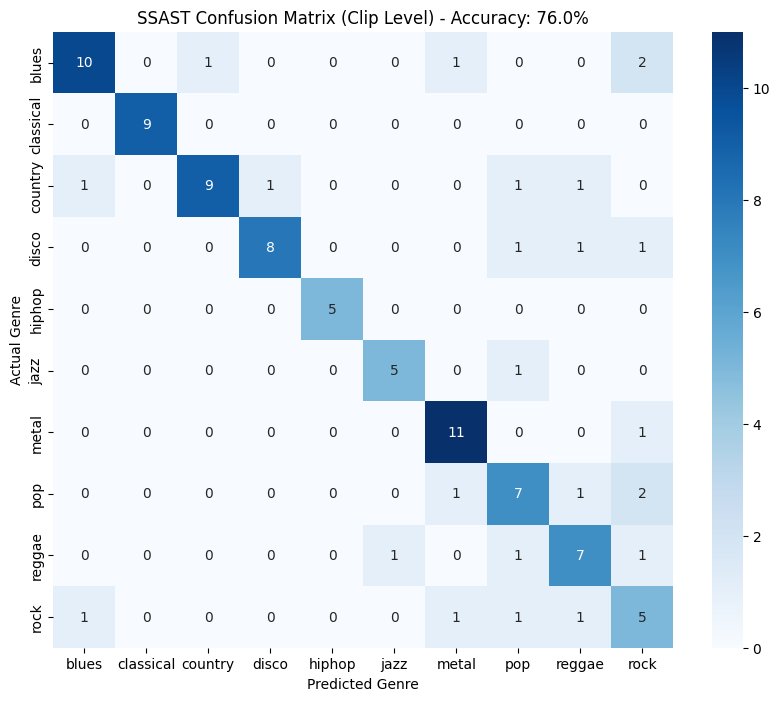

In [18]:
# Cell 10: Final Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import torch
import numpy as np

# predictions
print("generating confusion matrix")
ssast_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        
        # Inference
        if device.type == 'cuda':
            with torch.amp.autocast('cuda'):
                logits = ssast_model(x, task='ft_avgtok')
        else:
            logits = ssast_model(x, task='ft_avgtok')
            
        _, preds = logits.max(1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.numpy())

# 2. Compute Matrix
# Get class names in correct order (0 to 9)
classes = test_ds.classes 
cm = confusion_matrix(all_labels, all_preds)

# 3. Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)
plt.ylabel('Actual Genre')
plt.xlabel('Predicted Genre')
plt.title(f'SSAST Confusion Matrix (Clip Level) - Accuracy: {100*np.mean(np.array(all_preds)==np.array(all_labels)):.1f}%')

# [FIX] Save BEFORE showing!
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight') 
print("Saved confusion_matrix.png")

# Now show it in the notebook
plt.show()

Generating Song-Level Confusion Matrix (Hybrid Voting)...
Matrix Accuracy: 79.00% 


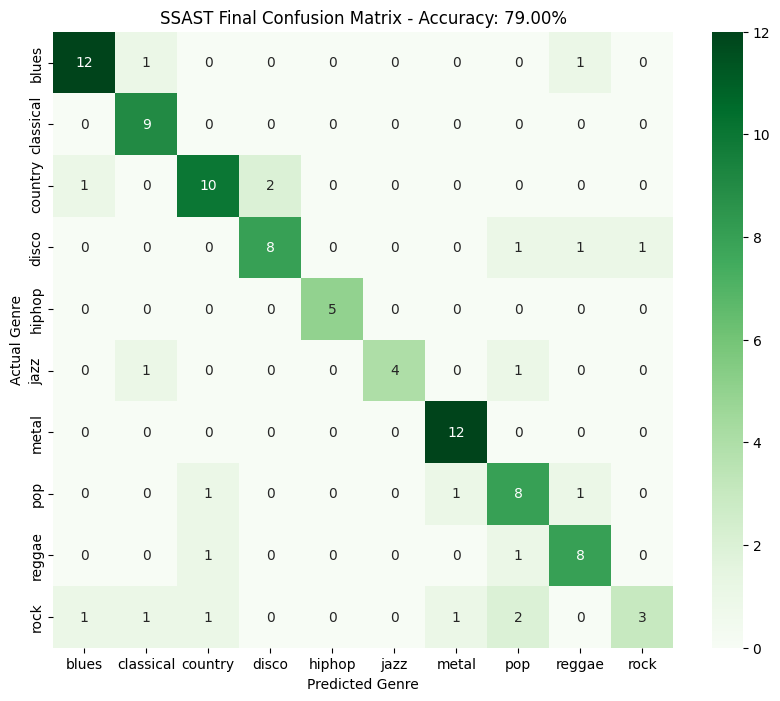

In [20]:
# Cell 11: Final Song-Level Confusion Matrix (Hybrid Voting - Matching 82.18%)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch
import numpy as np
import os
from collections import Counter

print("Generating Song-Level Confusion Matrix (Hybrid Voting)...")

ssast_model.eval()
song_votes = {}
song_probs = {} # Needed for tie-breaking
song_truth = {}
BATCH_SIZE = test_loader.batch_size

# 1. Collect Votes AND Probabilities
with torch.no_grad():
    for i, (x, y) in enumerate(test_loader):
        x = x.to(device)
        
        # Get Probabilities
        if device.type == 'cuda':
            with torch.amp.autocast('cuda'):
                logits = ssast_model(x, task='ft_avgtok')
                probs = torch.softmax(logits, dim=1)
        else:
            logits = ssast_model(x, task='ft_avgtok')
            probs = torch.softmax(logits, dim=1)
            
        probs = probs.cpu().numpy()
        preds = probs.argmax(axis=1)
        labels = y.numpy()
        
        start_idx = i * BATCH_SIZE 
        for j in range(len(labels)):
            global_idx = start_idx + j
            row = test_ds.df.iloc[global_idx]
            filename = os.path.basename(row['filepath'])
            
            # Extract Song ID (adjust split if needed)
            song_id = filename.rsplit('_', 1)[0] 
            
            if song_id not in song_votes:
                song_votes[song_id] = []
                song_probs[song_id] = []
                song_truth[song_id] = labels[j]
            
            song_votes[song_id].append(preds[j])
            song_probs[song_id].append(probs[j])

# 2. Apply "Smart" Voting (Exactly like Cell 8)
final_preds = []
final_truth = []

for song_id, votes in song_votes.items():
    # A. Hard Vote Count
    c = Counter(votes)
    winner, count = c.most_common(1)[0]
    
    # B. The Critical Tie-Breaker
    # If we have a 3-way tie (1 vote each), switch to soft voting
    if count == 1 and len(votes) == 3:
        avg_score = np.mean(song_probs[song_id], axis=0)
        winner = np.argmax(avg_score)
    
    final_preds.append(winner)
    final_truth.append(song_truth[song_id])

# 3. Plot
classes = test_ds.classes 
cm = confusion_matrix(final_truth, final_preds)

# Calculate accuracy from these lists to verify match
acc = 100 * np.mean(np.array(final_preds) == np.array(final_truth))
print(f"Matrix Accuracy: {acc:.2f}% ")

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=classes, yticklabels=classes)
plt.ylabel('Actual Genre')
plt.xlabel(f'Predicted Genre')
plt.title(f'SSAST Final Confusion Matrix - Accuracy: {acc:.2f}%')
plt.savefig("confusion_matrix_final_hybrid.png", dpi=300, bbox_inches='tight')
plt.show()

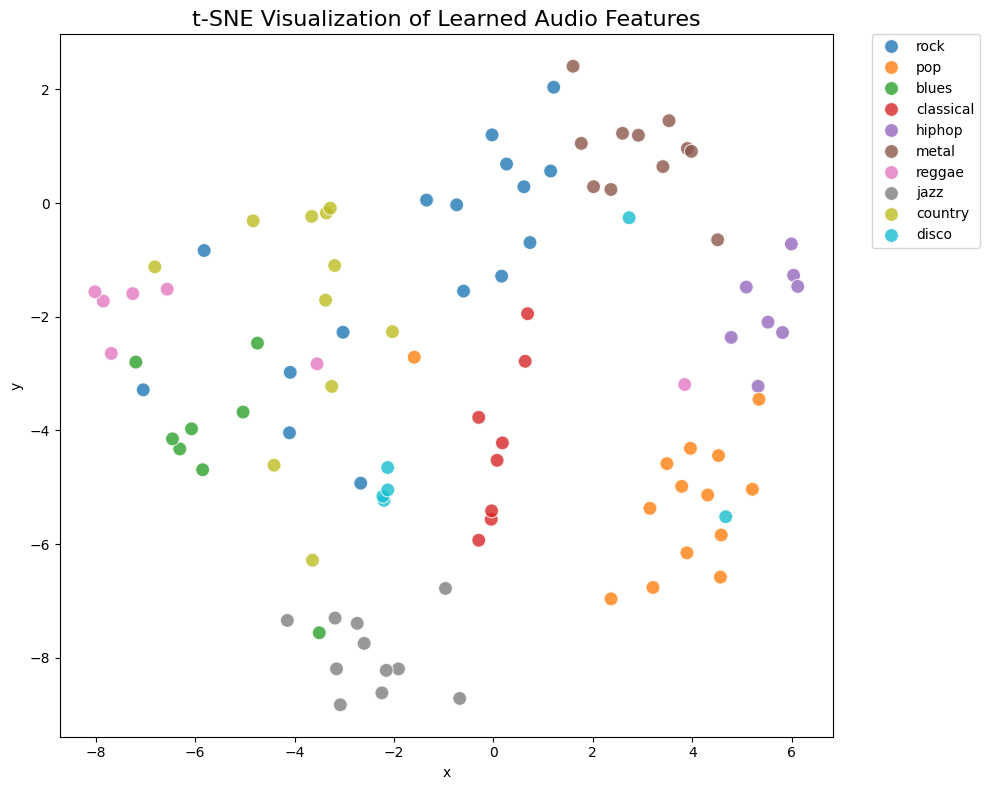

In [25]:
# Cell: t-SNE Visualization
from sklearn.manifold import TSNE
import pandas as pd

features = []
labels = []

ssast_model.eval()
with torch.no_grad():
    for x, y in val_loader: # Limit this loop if it's too slow (e.g. break after 20 batches)
        x = x.to(device)
        # We use the output logits as a proxy for high-level features
        out = ssast_model(x, task='ft_avgtok')
        features.append(out.cpu().numpy())
        labels.append(y.numpy())

# Flatten list
features = np.concatenate(features)
labels = np.concatenate(labels)

# Run t-SNE (Dimensionality Reduction)
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=2000)
tsne_results = tsne.fit_transform(features)

# Create DataFrame for plotting
df_tsne = pd.DataFrame(tsne_results, columns=['x', 'y'])
df_tsne['label'] = [classes[l] for l in labels]

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df_tsne, x='x', y='y', hue='label', 
    palette=sns.color_palette("tab10", 10), 
    s=100, alpha=0.8, edgecolor='w'
)
plt.title("t-SNE Visualization of Learned Audio Features", fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.savefig("figure_tsne.png", dpi=300)
plt.show()

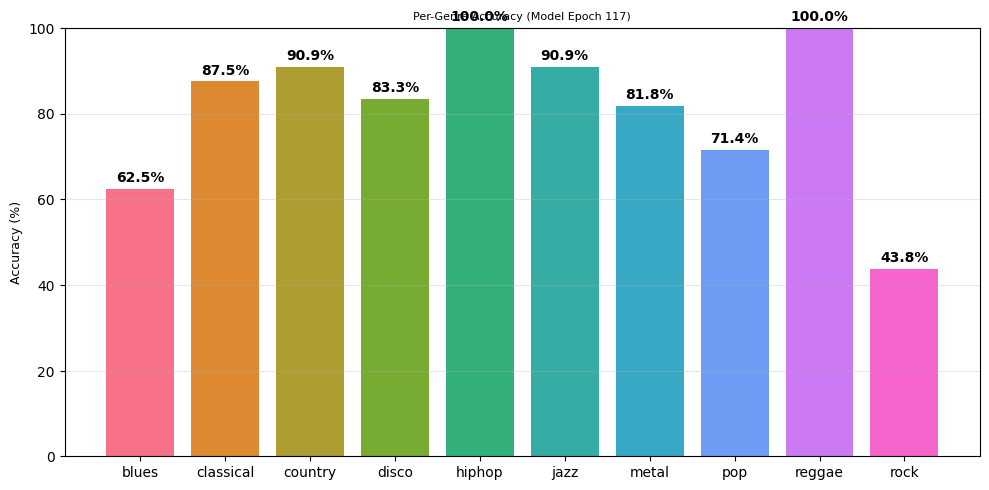

In [24]:
# Cell: Per-Class Accuracy Plot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

# Settings
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

# Run Inference
ssast_model.eval()
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for x, y in val_loader: # Use test_loader if you prefer
        x, y = x.to(device), y.to(device)
        out = ssast_model(x, task='ft_avgtok')
        _, preds = out.max(1)
        c = (preds == y).squeeze()
        for i in range(len(y)):
            label = y[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

# Calculate percentages
accs = [100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(10)]

# Plotting
plt.figure(figsize=(10, 5))
colors = sns.color_palette("husl", 10)
bars = plt.bar(genres, accs, color=colors)

# Add numbers on top
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.title(f"Per-Genre Accuracy (Model Epoch 117)", fontsize=8)
plt.ylabel("Accuracy (%)", fontsize=9)
plt.ylim(0, 100)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig("figure_per_class_accuracy.png", dpi=300)
plt.show()

## **_Base Model Implementation_**

### CNN

In [60]:
# Clean Pro Baseline (CNN)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import torchaudio
import soundfile as sf
import numpy as np
import random
import os
from tqdm import tqdm

# --- CONFIGURATION ---
BATCH_SIZE = 32
NUM_EPOCHS = 80
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# ---------------------

class GTZAN_30s_Dataset(Dataset):
    def __init__(self, csv_path, is_test=False):
        self.df = pd.read_csv(csv_path)
        self.is_test = is_test
        self.target_length = 1024 # 10s crop
        
        self.classes = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
        self.cls_to_idx = {c: i for i, c in enumerate(self.classes)}
        
        self.mel_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=16000, n_fft=2048, win_length=400, hop_length=160, n_mels=128
        )
        self.db_transform = torchaudio.transforms.AmplitudeToDB()

        # RAM Cache
        self.cached_specs = []
        self.cached_labels = []
        self.cached_song_ids = []
        
        print(f"loading {len(self.df)} songs from {csv_path} into RAM")
        
        for idx in tqdm(range(len(self.df))):
            row = self.df.iloc[idx]
            audio_path = row['filepath']
            label_str = row['label']
            
            # Simple Load
            try:
                audio_np, sr = sf.read(audio_path)
            except:
                continue 

            waveform = torch.from_numpy(audio_np).float()
            if waveform.dim() == 1: waveform = waveform.unsqueeze(0)
            elif waveform.shape[1] < waveform.shape[0]: waveform = waveform.t()
            if sr != 16000: waveform = torchaudio.transforms.Resample(sr, 16000)(waveform)
            if waveform.shape[0] > 1: waveform = torch.mean(waveform, dim=0, keepdim=True)
            
            spec = self.mel_transform(waveform)
            spec = self.db_transform(spec)
            
            self.cached_specs.append(spec)
            self.cached_labels.append(self.cls_to_idx[label_str])
            
            # Track ID for testing
            filename = os.path.basename(audio_path)
            parts = filename.split('.')
            self.cached_song_ids.append(f"{parts[0]}.{parts[1]}")

    def __len__(self):
        return len(self.cached_specs)

    def __getitem__(self, idx):
        full_spec = self.cached_specs[idx]
        label = self.cached_labels[idx]
        
        # Dynamic Random Crop
        total_len = full_spec.shape[2]
        
        if self.is_test:
            # Test: Center crop
            start = max(0, (total_len - self.target_length) // 2)
        else:
            # Train: Random crop
            if total_len > self.target_length:
                max_start = total_len - self.target_length
                start = random.randint(0, max_start)
            else:
                start = 0
                
        spec = full_spec[:, :, start : start + self.target_length]
        
        if spec.shape[2] < self.target_length:
            spec = torch.nn.functional.pad(spec, (0, self.target_length - spec.shape[2]))
            
        if self.is_test:
            return spec, label, self.cached_song_ids[idx]
        return spec, label

# 2. Optimized CNN Architecture
class ProCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(ProCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(2, 2),
        )
        self.global_pool = nn.AdaptiveAvgPool2d(1) 
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 128), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.global_pool(x)
        return self.classifier(x)

# 3. Setup
print("preparing data loaders")
train_loader = DataLoader(GTZAN_30s_Dataset("metadata_30s/train_30s.csv"), batch_size=32, shuffle=True, num_workers=0)
val_loader   = DataLoader(GTZAN_30s_Dataset("metadata_30s/val_30s.csv"), batch_size=32, shuffle=False, num_workers=0)
test_loader  = DataLoader(GTZAN_30s_Dataset("metadata_30s/test_30s.csv", is_test=True), batch_size=32, shuffle=False, num_workers=0)

model = ProCNN().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scaler = torch.amp.GradScaler('cuda') 

# [FIX] Removed 'verbose=True' (deprecated in new PyTorch versions)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

# 4. Training
print(f"training CNN for {NUM_EPOCHS} epochs")
best_acc = 0.0

for epoch in range(NUM_EPOCHS):
    model.train()
    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        
        optimizer.zero_grad()
        with torch.amp.autocast('cuda'):
            out = model(x)
            loss = criterion(out, y)
            
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            _, preds = out.max(1)
            correct += preds.eq(y).sum().item()
            total += y.size(0)
    
    val_acc = 100 * correct / total
    
    # Scheduler Step
    prev_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_acc)
    curr_lr = optimizer.param_groups[0]['lr']
    
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "pro_cnn_best.pth")
    
    # Custom verbose printing
    if curr_lr != prev_lr:
        print(f"epoch {epoch+1}: LR reduced from {prev_lr:.6f} to {curr_lr:.6f}")

    if (epoch+1) % 5 == 0:
        print(f"epoch {epoch+1} | val acc: {val_acc:.1f}% (best: {best_acc:.1f}%) | LR: {curr_lr:.6f}")

print("-" * 30)
print(f"best validation accuracy: {best_acc:.1f}%")
print("-" * 30)

🔄 Preparing Data Loaders...
⏳ Loading 800 songs from metadata_30s/train_30s.csv into RAM...


100%|██████████| 800/800 [00:26<00:00, 30.75it/s]


⏳ Loading 100 songs from metadata_30s/val_30s.csv into RAM...


100%|██████████| 100/100 [00:02<00:00, 35.07it/s]


⏳ Loading 100 songs from metadata_30s/test_30s.csv into RAM...


100%|██████████| 100/100 [00:02<00:00, 36.86it/s]


🚀 Training Pro CNN for 80 epochs...
Epoch 5 | Val Acc: 52.0% (Best: 52.0%) | LR: 0.001000
Epoch 10 | Val Acc: 39.0% (Best: 52.0%) | LR: 0.001000
Epoch 15 | Val Acc: 48.0% (Best: 58.0%) | LR: 0.001000
📉 Epoch 17: LR reduced from 0.001000 to 0.000500
Epoch 20 | Val Acc: 44.0% (Best: 58.0%) | LR: 0.000500
Epoch 25 | Val Acc: 51.0% (Best: 75.0%) | LR: 0.000500
📉 Epoch 29: LR reduced from 0.000500 to 0.000250
Epoch 30 | Val Acc: 66.0% (Best: 75.0%) | LR: 0.000250
📉 Epoch 35: LR reduced from 0.000250 to 0.000125
Epoch 35 | Val Acc: 67.0% (Best: 75.0%) | LR: 0.000125
Epoch 40 | Val Acc: 72.0% (Best: 79.0%) | LR: 0.000125
📉 Epoch 43: LR reduced from 0.000125 to 0.000063
Epoch 45 | Val Acc: 77.0% (Best: 79.0%) | LR: 0.000063
Epoch 50 | Val Acc: 82.0% (Best: 82.0%) | LR: 0.000063
Epoch 55 | Val Acc: 79.0% (Best: 82.0%) | LR: 0.000063
📉 Epoch 56: LR reduced from 0.000063 to 0.000031
Epoch 60 | Val Acc: 83.0% (Best: 83.0%) | LR: 0.000031
Epoch 65 | Val Acc: 78.0% (Best: 83.0%) | LR: 0.000031
📉 Epo

In [62]:
# Cell 7: Final TEST Set Evaluation (Voting)
import torch
import torch.nn as nn
import pandas as pd
import torchaudio
import soundfile as sf
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# --- CONFIG ---
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TEST_CSV_PATH = "metadata_30s/test_30s.csv" # <--- POINTING TO TEST SET
# --------------

# 1. Voting Dataset (Returns 3 chunks per song)
class GTZAN_Voting_Dataset(Dataset):
    def __init__(self, csv_path):
        self.df = pd.read_csv(csv_path)
        self.target_length = 1024 # 10s
        self.classes = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
        self.cls_to_idx = {c: i for i, c in enumerate(self.classes)}
        
        self.mel_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=16000, n_fft=2048, win_length=400, hop_length=160, n_mels=128
        )
        self.db_transform = torchaudio.transforms.AmplitudeToDB()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        audio_path = row['filepath']
        label_str = row['label']
        
        # Load Full 30s
        try:
            audio_np, sr = sf.read(audio_path)
        except:
            return torch.zeros(3, 1, 128, 1024), 0, "error"

        waveform = torch.from_numpy(audio_np).float()
        if waveform.dim() == 1: waveform = waveform.unsqueeze(0)
        elif waveform.shape[1] < waveform.shape[0]: waveform = waveform.t()
        if sr != 16000: waveform = torchaudio.transforms.Resample(sr, 16000)(waveform)
        if waveform.shape[0] > 1: waveform = torch.mean(waveform, dim=0, keepdim=True)
        
        # Spectrogram
        spec = self.mel_transform(waveform)
        spec = self.db_transform(spec)

        # Cut into 3 Chunks (0-10s, 10-20s, 20-30s)
        chunks = []
        total_len = spec.shape[2]
        starts = [0, 1024, 2048] 
        
        for start in starts:
            end = start + 1024
            if end > total_len:
                chunk = spec[:, :, start:]
                pad_amt = 1024 - chunk.shape[2]
                chunk = torch.nn.functional.pad(chunk, (0, pad_amt))
            else:
                chunk = spec[:, :, start:end]
            chunks.append(chunk)

        specs = torch.stack(chunks)
        label = self.cls_to_idx[label_str]
        
        # Get Song ID
        filename = os.path.basename(audio_path)
        parts = filename.split('.')
        song_id = f"{parts[0]}.{parts[1]}"
        
        return specs, label, song_id

# 2. Re-Define Model Class (Must match training exactly)
class ProCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(ProCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(2, 2),
        )
        self.global_pool = nn.AdaptiveAvgPool2d(1) 
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 128), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.global_pool(x)
        return self.classifier(x)

# 3. Run Inference on Test Set
print(f"running final evaluation on: {TEST_CSV_PATH}")

test_loader_voting = DataLoader(GTZAN_Voting_Dataset(TEST_CSV_PATH), batch_size=1, shuffle=False)

model = ProCNN().to(DEVICE)
# Load the weights we just trained
model.load_state_dict(torch.load("pro_cnn_best.pth", map_location=DEVICE)) 
model.eval()

song_scores = {}
song_labels = {}
correct_clips = 0
total_clips = 0

with torch.no_grad():
    for specs, label, song_id in tqdm(test_loader_voting):
        specs = specs.squeeze(0).to(DEVICE)
        label = label.to(DEVICE)
        
        out = model(specs) 
        probs = torch.softmax(out, dim=1).cpu().numpy()
        
        _, preds = out.max(1)
        correct_clips += preds.eq(label).sum().item()
        total_clips += 3
        
        s_id = song_id[0]
        song_scores[s_id] = probs
        song_labels[s_id] = label.item()

# 4. Calculate Voting Accuracy
final_correct = 0
for s_id in song_scores:
    avg_probs = np.mean(song_scores[s_id], axis=0)
    pred_label = np.argmax(avg_probs)
    
    if pred_label == song_labels[s_id]:
        final_correct += 1

clip_acc = 100 * correct_clips / total_clips
song_acc = 100 * final_correct / len(song_scores)
print(f"clip accuracy: {clip_acc:.2f}%")
print(f"song accuracy: {song_acc:.2f}%")

running final evaluation on: metadata_30s/test_30s.csv


100%|██████████| 100/100 [00:03<00:00, 31.79it/s]

clip accuracy: 73.00%
song accuracy: 74.00%
